# Integrated Single-Cell and Condition-Based Analyses

## Define File Paths

`file_path` can be a CellRanger output directory (barcode-features-matrix), an `AnnData` object or `.h5ad` file (or `MuData` object or file, etc. with further specifications, such as `assay=<assay key here>`, in the `Omics()` initialization function.)


Click the drop-down below for more documentation about arguments to `Omics()`.

<details>
<summary>Click here for more detailed documentation.</summary>

```python
    file_path (str, AnnData, or MuData): Path or object
        containing data. Used in initialization to create
        the initial `.adata` attribute (an AnnData or
        MuData object). Either
            - a path to a 10x directory (with matrix.mtx.gz,
            barcodes.tsv.gz, features.tsv.gz),
            - a path to an .h5ad or .mu file
                (Scanpy/AnnData/Muon-compatible),
            - an AnnData or MuData object (e.g., already
                loaded with Scanpy or Muon), or
            - a dictionary containing keyword arguments to
                pass to `corescpy.pp.combine_matrix_protospacer`
                (in order to load information about
                perturbations from other file(s); see
                function documentation), or
            - to concatenate multiple datasets, a dictionary
                (keyed by your desired subject/sample names
                to be used in `col_sample_id`) consisting
                of whatever objects you would pass to
                `create_object()`'s `file` argument for the
                individual objects. You must also specify
                `col_sample` (a tuple as described in the
                documentation below). The other arguments
                passed to the `corescpy.pp.create_object()`
                function (e.g., `col_gene_symbols`) can be
                specified as normal if they are common across
                samples; otherwise, specify them as lists in
                the same order as the `file` dictionary.
    prefix (str, optional):
        As per Scanpy documentation: 'Any prefix before
        matrix.mtx, genes.tsv and barcodes.tsv. For instance,
        if the files are named patientA_matrix.mtx,
        patientA_genes.tsv and patientA_barcodes.tsv the prefix
        is patientA_. (Default: no prefix)' Defaults to None.
    assay (str, optional): Name of the gene expression assay if
        loading a multi-modal data object (e.g., "rna").
        Defaults to None.
    assay_protein (str, optional): Name of the assay containing
        the protein expression modality, if available.
        For instance, if "adt", `self.adata["adt"]` would be
        expected to contain the AnnData object for the
        protein modality. ONLY FOR MULTI-MODAL DATA for certain
        bonus visualization methods. Defaults to None.
    col_gene_symbols (str, optional): Specify "gene_symbols"
        to use gene names or "gene_ids" to use EnsemblIDs) as
        the index of `.var`. Defaults to "gene_symbols".
    col_cell_type (str, optional): Column name in `.obs` for
        cell type. Defaults to "leiden" (anticipating that you
        will run `self.cluster(...)` with
        `method_cluster="leiden"`). This column may be
        - pre-existing in data (e.g., pre-run clustering column
            or manual annotations), or
        - expected to be created via `Crispr.cluster()`.
    col_sample_id (str or tuple, optional): Column in `.obs`
        with sample IDs. Defaults to "standard_sample_id".
        If this column does not yet exist in your data and
        needs to be created by concatenating datasets,
        you must provide `file_path` as a dictionary keyed
        by desired `col_sample_id` values as well as signal
        that concatenation needs to happen by specifying
        `col_sample_id` as a tuple, with the second element
        containing a dictionary of keyword arguments to pass to
        `AnnData.concatenate()` or None (to use defaults).
```
</details>

---

**To integrate samples**, see the Single Cell Integration workflow, or click the drop-down below for a brief example of how you would specify the arguments. 
* The main idea is that you specify preprocessing and clustering keyword arguments up-front so that the samples can be individually processed before integration. 
* Then, you can follow the workflow in this notebook pretty much as normal, except skipping the `self.preprocess()` step (e.g., start with clustering the integrated object, then proceed downstream).
* The integrated object should have an attribute `._integrated` that signals the clustering method to set `kws_pca=False` in `self.cluster()` so that the Harmony-adjusted PCA created during integration (rather than a newly-calculated one) will be used. To be safe, you could set `kws_pca=False` yourself too.
* Note that in the example below, all samples use the same pre-processing and clustering parameters.
  * You could also specify a list of different sets for each sample in the same order as in `file_path` (e.g., the first list element of the list would be the dictionary of arguments applied to sample `PSC001`.).
  * For example, you could define different dictionaries of arguments called `kws_pp_psc001`, `kws_pp_psc002`, `kws_pp_psc003`, then change the line below defining `kws_pp` to `kws_pp = [kws_pp_psc001, kws_pp_psc002, kws_pp_psc003]`.
  * You can do the same for `kws_init` and `kws_cluster`.

<details>
<summary>Click here for example integration code.</summary>

```python
file_path = {"PSC001": "path/to/cellranger_or_object_file/for/PSC001", 
             "PSC002": "path/to/cellranger_or_object_file/for/PSC002", 
             "PSC003": "path/to/cellranger_or_object_file/for/PSC003"}
# file_path = {"PSC001": psc001_anndata_object, 
#              "PSC002": psc001_anndata_object, 
#              "PSC003": psc001_anndata_object}  # alternatively, pass objects
kws_init = {}
outlier_mads = {
    "n_genes_by_counts": [5, None], "pct_counts_mt": [None, 3],
    "pct_counts_ribo": [None, 5], "pct_counts_hb": [None, 5],
    "total_counts": [5, None],  # will filter both genes & cells
    "log1p_total_counts": [5, None], "log1p_n_genes_by_counts": [5, None]
}
kws_pp = {"regress_out": None, "kws_scale": "log",
          "gene_filter_n_cell": [3, None], "outlier_mads": outlier_mads}
kws_cluster = {"method_cluster": "leiden", "kws_umap":  {"min_dist": 0.3},
               "kws_neighbors": None, "kws_cluster": {},
               "kws_pca": {"use_highly_variable": True},
               "resolution": 0.5, "n_comps": 30}
kws_harmony = {"plot_convergence": True, "random_state": 0}

kws_multi = dict(kws_init=kws_init, kws_pp=kws_pp,
                 kws_cluster=kws_cluster, kws_harmony=kws_harmony)

self = Omics(file_path, col_sample_id="sample_id", kws_multi=kws_multi)
```
</details>

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import matplotlib.pyplot as plt
import seaborn as sb
import scanpy as sc
import pandas as pd
import corescpy as cr
from corescpy import Omics

# Options
key_multiple, key_unassigned = "multiple", "unassigned"
drop_conditions = [key_multiple, key_unassigned]
load = True  # reload from previous run of this notebook, where available?
DIR = "/mnt/cho_lab/disk2/elizabeth/projects/crispr-screening"
file_perts = os.path.join(DIR, "data/04172024_CRISPRi_IBD_guides.xlsx")
file_ann = os.path.join(os.path.expanduser("~"),
                        "corescpy/examples/markers_lineages.csv")
src_dir = os.path.join(DIR, "analysis/corescpy")  # previously-created objects
out_dir = str(f"/mnt/cho_lab/disk2/{os.getlogin()}/projects/crispr-screening/"
              "analysis/corescpy")  # output directory
# out_dir = None
files = {
    "HH03": dict(directory=f"{DIR}/data/HH03"),
    "HH04": dict(directory=f"{DIR}/data/HH04"),
    "HH05": dict(directory=f"{DIR}/data/HH05"),
    "HH06": dict(directory=f"{DIR}/data/HH06"),
    "HH07": dict(directory=f"{DIR}/data/HH-Hu-CR5"),
    "HH09": dict(directory=f"{DIR}/data/HH-Hu-CR4")
}

# Guide RNA & scRNA-seq Preprocessing Arguments
outlier_mads = {"pct_counts_mt": [None, 5],
                "pct_counts_ribo": [None, 5],
                "n_counts": [5, None]}
kws_pp = {"kws_hvg": True, "target_sum": 1e4, "kws_scale": "log",
          "regress_out": None, "outlier_mads": outlier_mads,
          "cell_filter_ngene": [3, None], "gene_filter_n_cell": [3, None]}

# Clustering & Annotation Arguments
kws_cluster = {"kws_umap": {"min_dist": 0.3}, "use_highly_variable": True,
               "resolution": 1.2}
model_celltypist = "Immune_All_Low.pkl"  # for CellTypist annotation
# keys_marker_cell_types = None  # use all cell type markers for E. annotation
col_annotation = "group"  # `file_ann` column to use for annotation

# Define Column Names, Keys for Control, Metadata, etc.
kwargs_init = dict(col_gene_symbols="gene_symbols",
                   col_cell_type="leiden",
                   col_sample_id="sample",
                   col_condition="perturbation",
                   col_target_genes="target_gene",
                   col_perturbed="perturbed",
                   col_guide_rna="feature_call",
                   col_num_umis="num_umis",
                   key_control="NEG_CTRL",
                   key_treatment="KD")  # common b/t samples
ids = {
    "HH03": {"MDP": "No MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH04": {"MDP": "MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH05": {"MDP": "No MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH06": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH07": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR5"},
    "HH09": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR4"}
}  # metadata per-sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
self = cr.Omics(files, kws_multi=dict(kws_pp=kws_pp, kws_cluster=kws_cluster))



<<< INITIALIZING OMICS CLASS OBJECT >>>





col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="unique.idents"
col_batch="unique.idents"
col_subject=None
col_condition=None
col_num_umis=None








key_control=None
key_treatment=None
key_table=None






<<< INITIALIZING OMICS CLASS OBJECT >>>





col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="unique.idents"
col_batch="unique.idents"
col_subject=None
col_condition=None
col_num_umis=None








key_control=None
key_treatment=None
key_table=None






<<< LOADING PROTOSPACER METADATA >>>


Counts: Initial


	Observations: 15078

	Genes: 36601







 AnnData object with n_obs × n_vars = 15078 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'
    layers: 'counts' 

                      gene_ids    feature_types
gene_symbols                                  
MIR1302-2HG   ENSG00000243485  Gene Expression
FAM138A       ENSG00000237613  Gene Expres

## Clustering



`kws_pca`=False. Using existing if present:

AnnData object with n_obs × n_vars = 82331 × 36601
    obs: 'feature_call', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden', 'unique.idents'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts-HH03', 'mean_counts-HH03', 'log1p_mean_counts-HH03', 'pct_dropout_by_counts-HH03', 'total_counts-HH03', 'log1p_total_counts-H

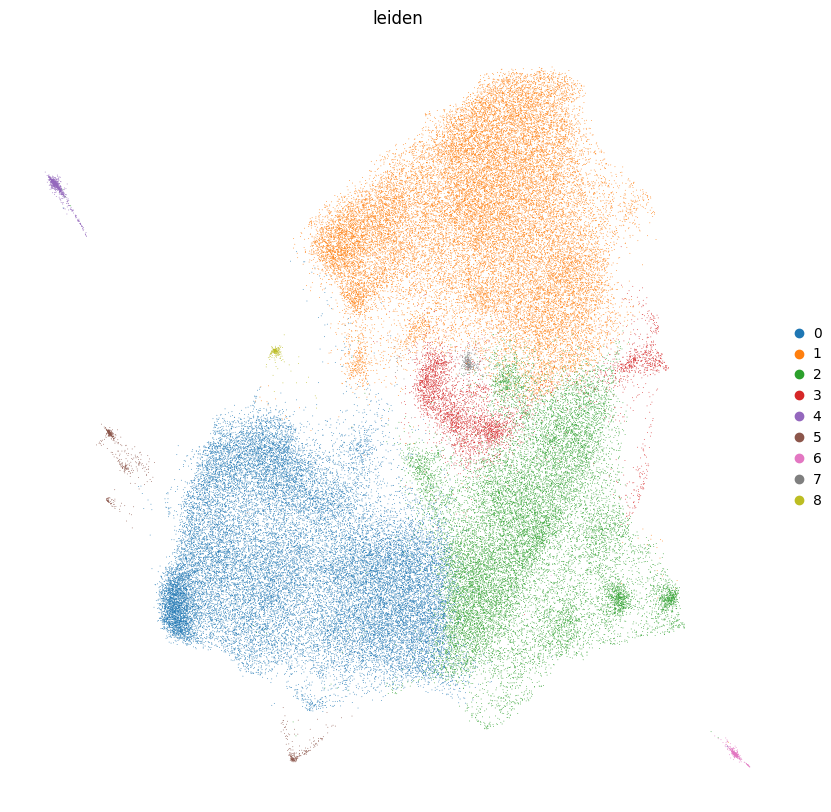

In [ ]:
_ = self.cluster(resolution=1.2, n_comps=30,
                 kws_pca=False, kws_umap={"min_dist": 0.3})
self.plot_umap()

In [ ]:
# self.write_h5ad("/mnt/cho_lab/disk2/elizabeth/data/integrated_example.h5ad")

## Find Markers/DEGs

See the Single Cell tutorial for more details and options.

                   scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
leiden names                                                                
0      TMSB4X  105.613220        0.544847    0.0        0.0      0.999897   
       TMSB10   92.688385        0.479221    0.0        0.0      0.996614   
       FTL      82.992569        0.408940    0.0        0.0      1.000000   

               pct_nz_reference  n_cells  
leiden names                              
0      TMSB4X          0.999435    29240  
       TMSB10          0.995611    29240  
       FTL             1.000000    29240  
                   scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
leiden names                                                                
1      MALAT1  121.972389        2.246995    0.0        0.0      0.997088   
       LRMDA   113.378357        1.680199    0.0        0.0      0.863764   
       ZEB2    112.948189        1.295459    0.0        0.0      0.962567   

             

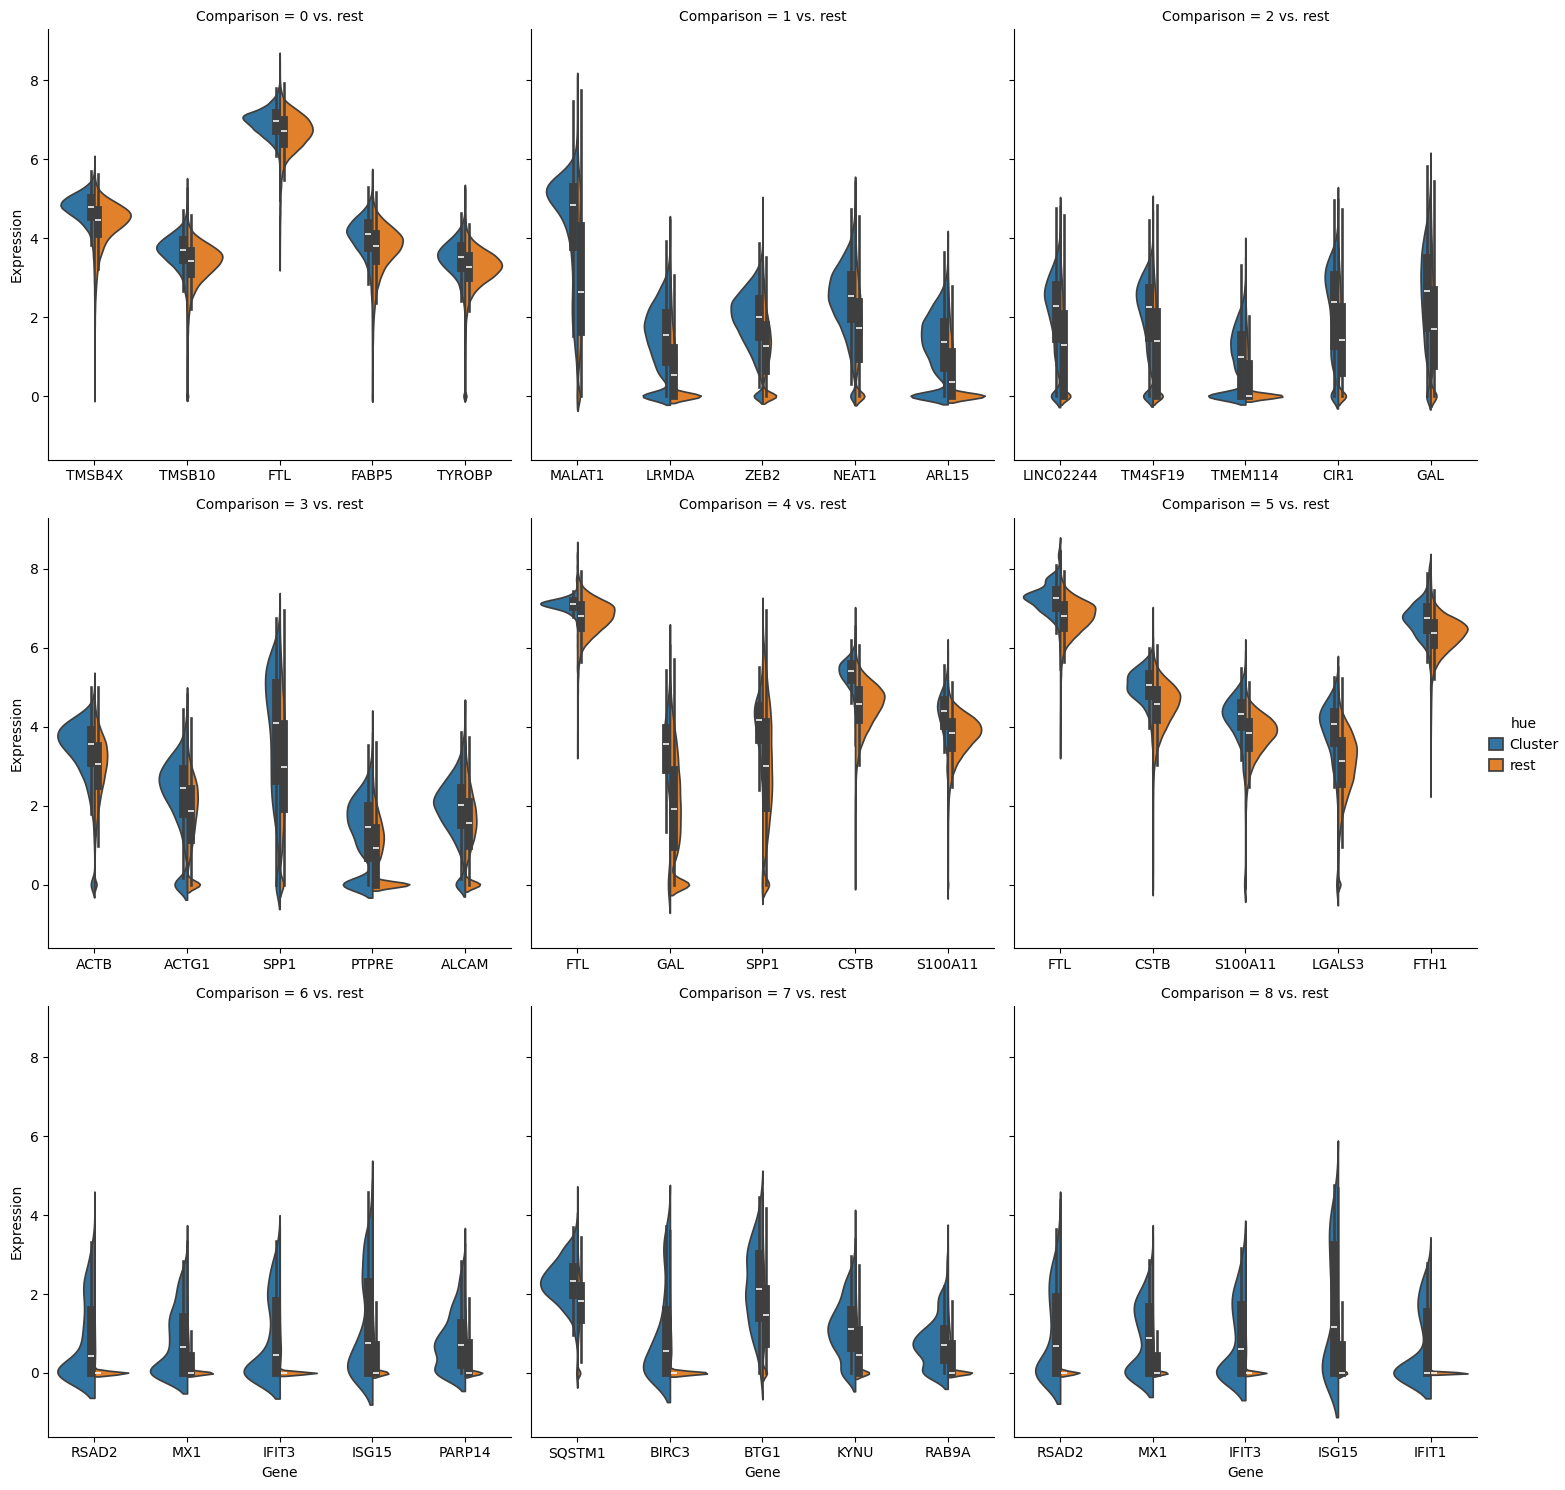

In [ ]:
marks, figs_deg = self.find_markers(n_genes=20)

## CellTypist Annotation

👉 Detailed model information can be found at `https://www.celltypist.org/models`


🔬 Input data has 82331 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


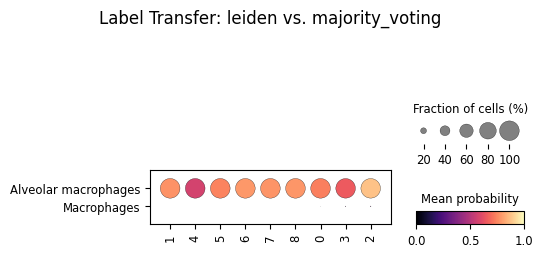

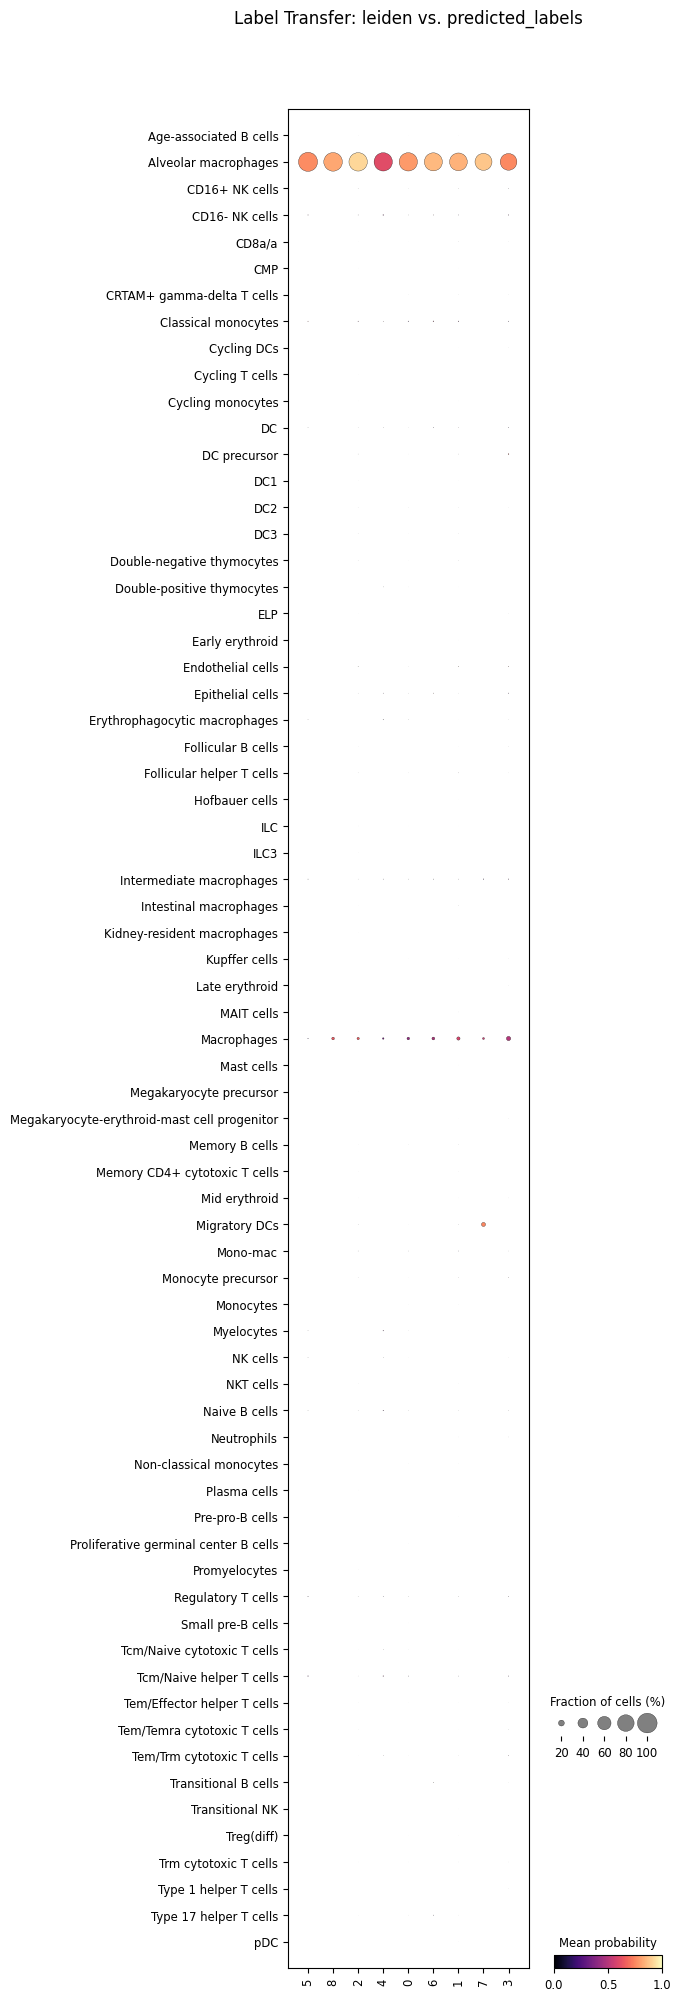

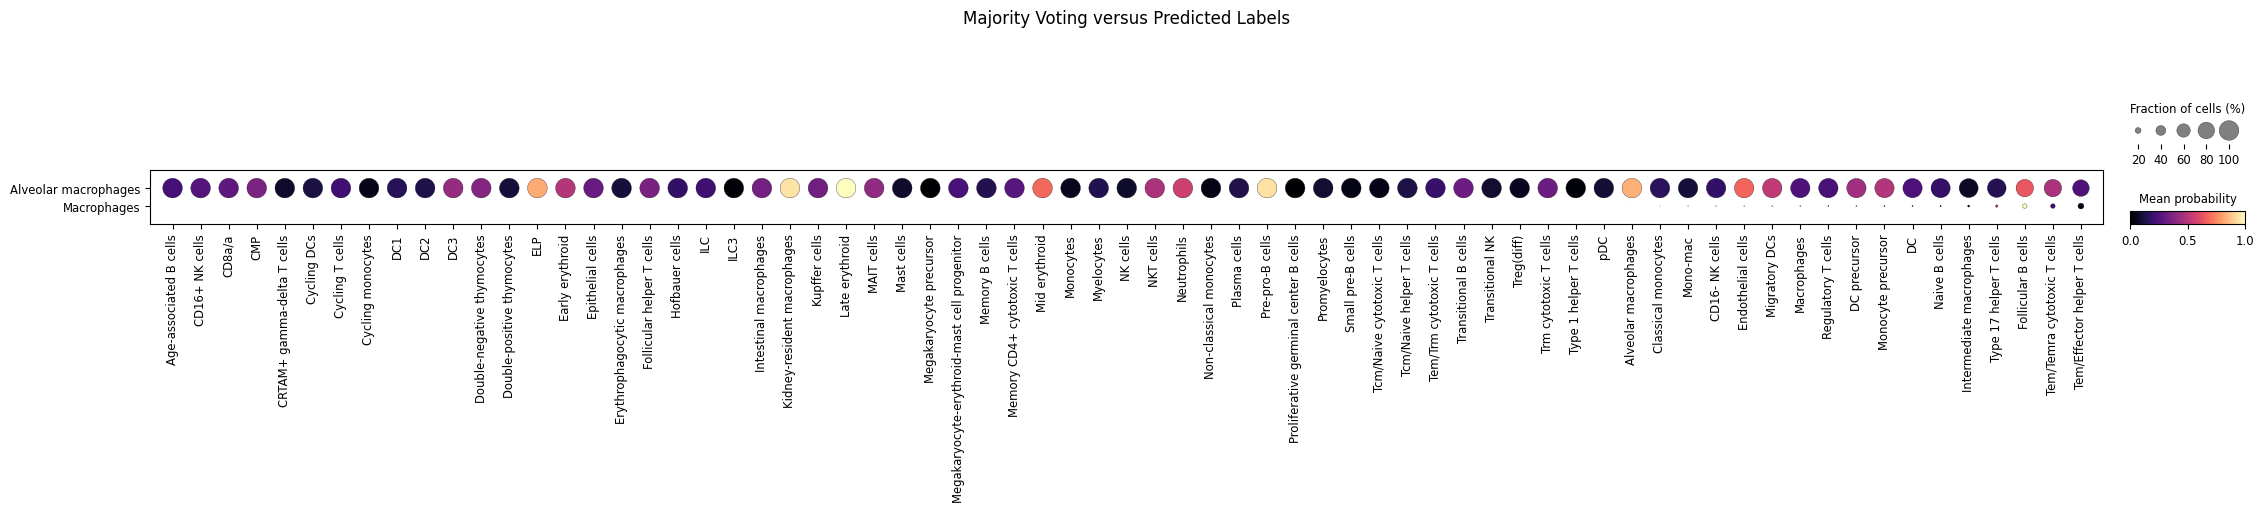




Confidence Scores

 conf_score              count  mean   std  min   25%   50%   75%  max
majority_voting                                                      
Alveolar macrophages  82116.0  0.80  0.30  0.0  0.70  0.97  1.00  1.0
Macrophages             215.0  0.51  0.35  0.0  0.16  0.47  0.86  1.0 


AnnData object with n_obs × n_vars = 82331 × 36601
    obs: 'feature_call', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gen

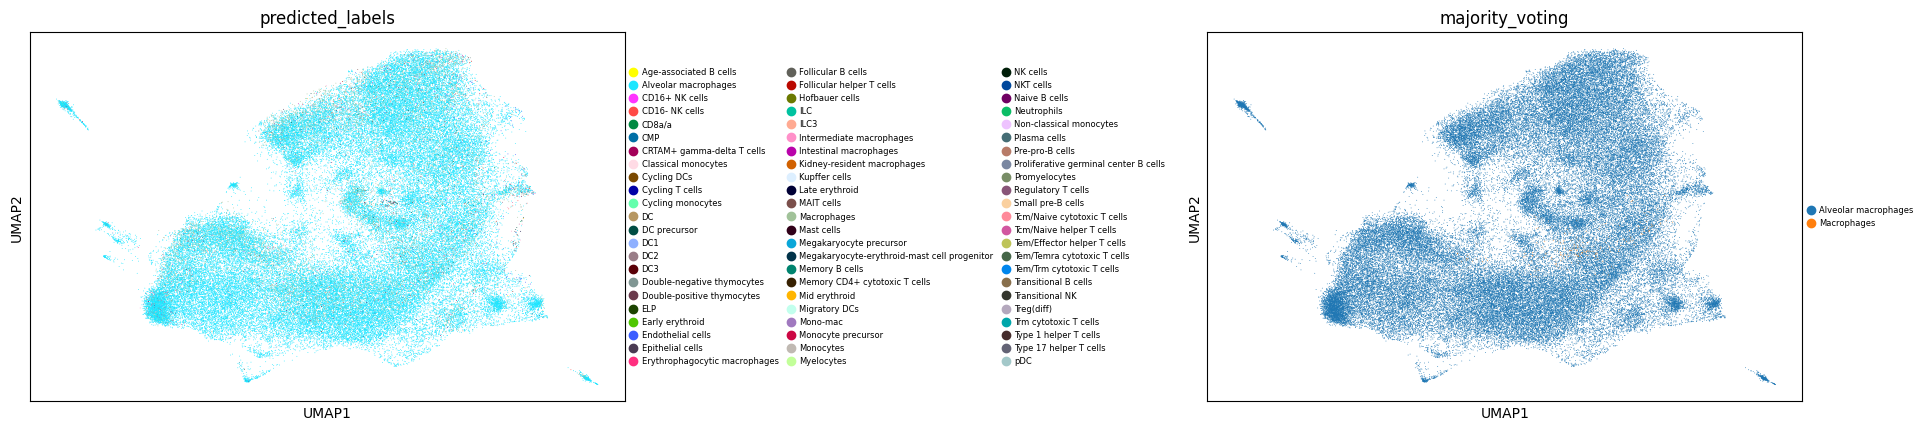

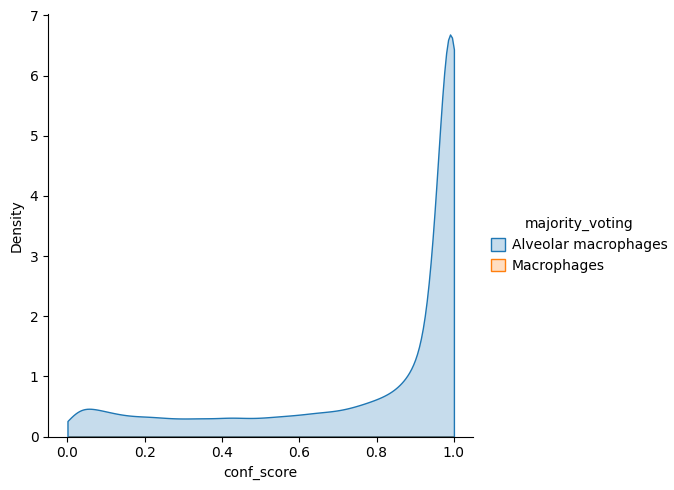

In [ ]:
self.annotate_clusters("Immune_All_Low.pkl", col_cell_type="leiden")
self._columns["col_cell_type"] = "majority_voting"

## Analyses

Remember that you can set `col_condition`, `col_cell_type`, `key_treatment`, `key_control`, etc. as arguments to methods below if you don't want to use the defaults set when you initialized the object or changed later by modifying `self._columns` and/or `self._keys`.

### Ligand-Receptor

CellphoneDB

In [ ]:
_, res_lr, figs_lr = self.calculate_receptor_ligand()

### Causal Network Analysis

This won't be run because we don't have conditions in these data, but if you did, specify `col-condition` in `self.calculate_receptor_ligand()`, then run `self.calculate_causal_network()`.

In [ ]:
key_source, key_target = "T cells", "Macrophages"
res_cn, prob, fig_cn = self.calculate_causal_network(key_source, key_target)

### Gene Set Enrichment Analysis

In [ ]:
self.run_gsea()

### Multi-Cellular Programs

In [ ]:
self.run_dialogue(n_programs=3)

### Composition Analysis

In [ ]:
self.run_composition_analysis()